# Brain Tumor Detection by using MRI Images🧠🩺

In [2]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [3]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set_style('darkgrid')
%matplotlib inline
init_notebook_mode(connected=True)
RANDOM_SEED = 101

## Dataset

- `NO` - no tumor, encoded as `0`
- `YES` - tumor, encoded as `1`

 Right now all images are in one folder with yes and no subfolders. I will split the data into train, val and test folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [5]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

## Data import and Preprocessing

In [7]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i=0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _  = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.23it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 47.59it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 17.66it/s]

50 images loaded from VAL/ directory.


## Distribution of classes among sets:

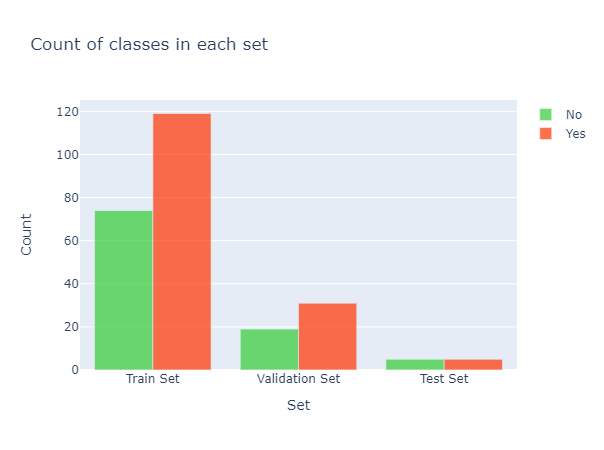

In [11]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title':'Set'},
    yaxis={'title':'Count'}
)
fig = go.Figure(data,layout)
iplot(fig)

## Plot samples

In [13]:
def plot_samples(X,y,labels_dict, n=50):
    """
        Create a gridplot for desired number of images (n) from specified set
    """ 
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y==index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

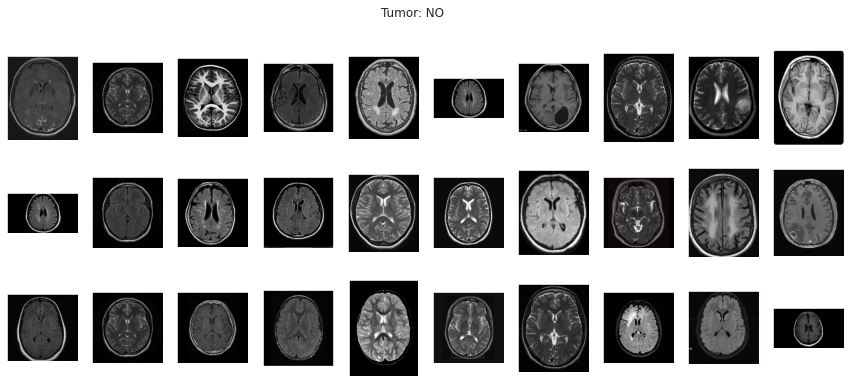

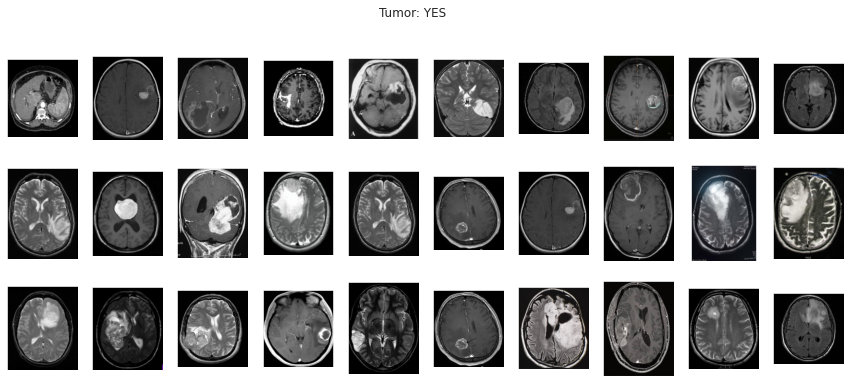

In [14]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different width and height and diffent size of "black corners". Since the image size for VGG-16 imput layer is (224,224) some wide images may look weird after resizing. Histogram of ratio distributions (ratio = width/height):

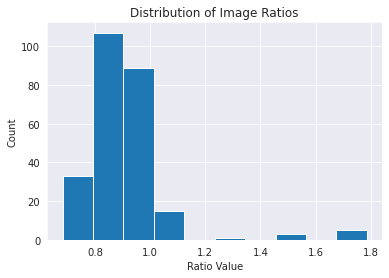

In [16]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images.

`Erosion is an operation that erodes away the boundaries of foreground objects. It is performed by applying a structuring element (kernel) to the image and replacing the central pixel of the kernel with the minimum value of the pixels under the kernel. This reduces the size of the foreground objects and eliminates small white pixels (noise) from the image.

Dilation is the opposite of erosion. It expands the boundaries of the foreground objects by replacing the central pixel of the kernel with the maximum value of the pixels under the kernel. This increases the size of the foreground objects and fills small holes in the objects.`

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
        Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5,5), 0)
        '''
            is used to blur an image by applying a Gaussian filter to it. 
            The Gaussian filter is a type of low-pass filter that is used to remove 
            noise and high-frequency information from an image, 
            making it appear smoother and less grainy.
        '''
        
        # threshold the image then perform a series of erosions + 
        # dilations to remove any small region of noise
        
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        '''
        Thresholding is a process of converting an image into a binary image based on a specified threshold value. 
        The pixels in the image are compared to the threshold value, 
        and if the value of a pixel is greater than the threshold value, 
        it is set to 255 (white), otherwise it is set to 0 (black).
        '''
        thresh = cv2.erode(thresh, None, iterations=2)
        
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find the contours in threshold image, then grad the largest one
        '''
         defined as the boundaries of an object in an image. They can be thought of as the curves that enclose an object in an image 
         and separate it from the rest of the image. 
         Contours are a powerful tool for image analysis and processing, as they provide information 
         about the shape, size, and orientation of objects in an image.
        '''
        cnt = cv2.findCon
        